In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GroupKFold
from sklearn import metrics
import scipy.stats as stats
import random
from os.path import join
import pandas as pd
import xlsxwriter
import openpyxl
import os
import numpy as np
from pandas import Series, ExcelWriter
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc 
from anndata import AnnData
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys  
sys.path.insert(0, '../../my_packages')
import dimen_reduc
import meta_ord
import paga_res
import sliding_window
import statistic
from roc_ps import all_func

#### Variables

In [3]:
top_path = 'C:/Users/morts/Documents/TAU/Manifold_Project/Data/Serrano_Ravel13_Ravel11_Carter22/ps_res/'

file_name = top_path + 'ps_res_16052023.xlsx'
nn_file_name = top_path + 'nn_res_30052023.xlsx'

sheet_abun = 'abundance'
sheet_meta = 'meta'
sheet_umap = 'umap'
sheet_pcoa = 'pcoa'

#### Load data

In [4]:
meta = pd.read_excel(file_name, sheet_name = sheet_meta, index_col = 0)
nn_meta = pd.read_excel(nn_file_name, sheet_name = sheet_meta, index_col = 0)
print(meta.shape)
print(nn_meta.shape)

(7842, 31)
(514, 35)


In [5]:
both_meta = pd.concat([meta, nn_meta])

#### Separate to two parts

In [6]:
def get_shuffled_df(df, n, label_col):
    ## Order df
    filt_df = df[[label_col]]
    filt_df.reset_index(drop = True, inplace = True)
    
    ## Permutations
    for i in range(n):
        shuff_arr = filt_df[label_col].sample(frac = 1).reset_index(drop = True)
        colname = 'shuff_' + str(i)
        filt_df[colname] = shuff_arr
        
    return filt_df
        
def get_roc_auc(label_arr, pred_arr, shuff_num):
    fpr, tpr, _ = metrics.roc_curve(label_arr, pred_arr)
    auc = metrics.roc_auc_score(label_arr, pred_arr)
    res_df = pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'auc': auc})
    res_df['shuff_num'] = shuff_num
    
    return res_df

def get_roc(shuffled_df, pred_arr):
    ## Create df
    final_df = pd.DataFrame(columns = ['fpr', 'tpr', 'auc', 'shuff_num'])
    
    for col in shuffled_df.columns:
        res_df = get_roc_auc(shuffled_df[col], pred_arr, col)
        final_df = pd.concat([final_df, res_df])
    
    return final_df

def all_func(df, n, label_col, pred_col):
    filt_df = df[df[label_col].notna()]
    pred_arr = filt_df[pred_col].to_numpy()
    
    shuffled_df = get_shuffled_df(filt_df, n, label_col)
    final_df = get_roc(shuffled_df, pred_arr)
    
    return final_df, shuffled_df

def get_roc_all(df, long_df, col, pred_col):
    new_long_df = long_df[col]
    stay_subjects = new_long_df[new_long_df['beginning'] == 0].index
    new_df = df.join(new_long_df[['late']]).loc[stay_subjects]
    
    pred_df, shuff = all_func(new_df, 99, 'late', pred_col)
    
    return pred_df, shuff

In [7]:
temp_meta = both_meta[both_meta['db'].str.contains('temp')]
temp_meta = temp_meta.sort_values(['subjectID', 'time'], ascending = [True, True])
# temp_meta['ex_part'] = np.where(temp_meta['time'] < 10, 'beginning', 'late')

In [8]:
predict_group_size = 10
no_bv_first_index = temp_meta.loc[temp_meta.BV_bin == 0].groupby('subjectID').head(predict_group_size).index
temp_meta['ex_part'] = np.where(temp_meta.index.isin(no_bv_first_index), 'beginning', 'late')

In [17]:
beg_meta = temp_meta[temp_meta['ex_part'] == 'beginning'].groupby('subjectID')['mt_pseudotime'].aggregate(['min', 'max', 'mean', 'std', 'median'])
beg_meta['diff'] = beg_meta['max'] - beg_meta['min']
bv_meta = temp_meta.groupby(['subjectID', 'ex_part'])['BV_bin', 'nugent_bin', 'ph_bin'].sum().reset_index()
long_bv_meta = bv_meta.pivot(index = 'subjectID', columns = 'ex_part', values = ['BV_bin', 'nugent_bin', 'ph_bin'])
long_bv_meta[long_bv_meta > 1] = 1

In [10]:
long_bv_meta.BV_bin.sum()

ex_part
beginning     0.0
late         18.0
dtype: float64

In [20]:
new_long_df = long_bv_meta['BV_bin']
stay_subjects = new_long_df[new_long_df['beginning'] == 0].index
new_df = beg_meta.join(new_long_df[['late']]).loc[stay_subjects]

<AxesSubplot:title={'center':'std'}, xlabel='late'>

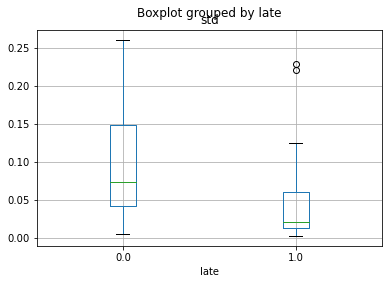

In [25]:
new_df.boxplot(by = 'late', column = 'std')

In [28]:
from scipy.stats import mannwhitneyu

 
group1 = new_df[new_df['late'] == 0]['std']
group2 = new_df[new_df['late'] == 1]['std']
 
# conduct the Wilcoxon-Signed Rank Test
mannwhitneyu(group1, group2)

MannwhitneyuResult(statistic=323.0, pvalue=0.0023368825104975004)

In [26]:
new_df[new_df['late'] == 0]['std']

subjectID
UAB001    0.097700
UAB002    0.153365
UAB004    0.248158
UAB005    0.149155
UAB006    0.048980
            ...   
UAB124    0.176745
UAB125    0.209939
UAB129    0.058156
UAB132    0.249166
UAB133    0.063775
Name: std, Length: 64, dtype: float64

In [18]:
pred_df_nug, shuff = get_roc_all(beg_meta, long_bv_meta, 'nugent_bin', 'diff')
pred_df_ph, shuff = get_roc_all(beg_meta, long_bv_meta, 'ph_bin', 'diff')
pred_df_bv, shuff = get_roc_all(beg_meta, long_bv_meta, 'BV_bin', 'diff')

#### Save

In [23]:
dict_roc = {'bv': new_df}
roc_path = top_path + '10days_without_bv_diff_04062023.xlsx'
paga_res.save_excel(roc_path, dict_roc)

#### t-test

In [ ]:
dict_roc = {'nug': pred_df_nug, 'bv': pred_df_bv, 'ph': pred_df_ph}
roc_path = top_path + 'bv_predict_ps_notfirst_mean_01062023.xlsx'
paga_res.save_excel(roc_path, dict_roc)

#### Predict

In [252]:
def get_shuffled_df(df, n, label_col):
    ## Order df
    filt_df = df[[label_col]]
    filt_df.reset_index(drop = True, inplace = True)
    
    ## Permutations
    for i in range(n):
        shuff_arr = filt_df[label_col].sample(frac = 1).reset_index(drop = True)
        colname = 'shuff_' + str(i)
        filt_df[colname] = shuff_arr
        
    return filt_df
        
def get_roc_auc(label_arr, pred_arr, shuff_num):
    fpr, tpr, _ = metrics.roc_curve(label_arr, pred_arr)
    auc = metrics.roc_auc_score(label_arr, pred_arr)
    res_df = pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'auc': auc})
    res_df['shuff_num'] = shuff_num
    
    return res_df

def get_roc(shuffled_df, pred_arr):
    ## Create df
    final_df = pd.DataFrame(columns = ['fpr', 'tpr', 'auc', 'shuff_num'])
    
    for col in shuffled_df.columns:
        res_df = get_roc_auc(shuffled_df[col], pred_arr, col)
        final_df = pd.concat([final_df, res_df])
    
    return final_df

def all_func(df, n, label_col):
    filt_df = df[df[label_col].notna()]
    pred_arr = filt_df['std'].to_numpy()
    
    shuffled_df = get_shuffled_df(filt_df, n, label_col)
    final_df = get_roc(shuffled_df, pred_arr)
    
    return final_df, shuffled_df

In [189]:
pred_df, shuff = all_func(beg_meta, 99, 'late')

In [191]:
dict_roc = {'late': pred_df}
roc_path = top_path + 'bv_redict_ps_01062023.xlsx'
paga_res.save_excel(roc_path, dict_roc)

In [172]:
pred_df

(         fpr       tpr       auc shuff_num
 0   0.000000  0.000000  0.916667      late
 1   0.000000  0.333333  0.916667      late
 2   0.062500  0.333333  0.916667      late
 3   0.062500  0.666667  0.916667      late
 4   0.187500  0.666667  0.916667      late
 ..       ...       ...       ...       ...
 4   0.625000  0.333333  0.458333  shuff_98
 5   0.625000  0.666667  0.458333  shuff_98
 6   0.703125  0.666667  0.458333  shuff_98
 7   0.703125  1.000000  0.458333  shuff_98
 8   1.000000  1.000000  0.458333  shuff_98
 
 [850 rows x 4 columns],
     late  shuff_0  shuff_1  shuff_2  shuff_3  shuff_4  shuff_5  shuff_6  \
 0    0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
 1    0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
 2    0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
 3    0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
 4    0.0      0.0      0.0      0.0      1.0      0.0      0.0  

In [35]:
def get_roc(df, x_col, y_col):
    filt_df = df[df[y_col].notna()]
    X = filt_df[[x_col]]
    y = filt_df[y_col] 
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1) 
    log_regression = LogisticRegression(penalty = 'l2', random_state = 0)
    log_regression.fit(X_train, y_train)    
    y_pred_proba = log_regression.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    
    res_df = pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'auc': auc})
    
    return res_df#, fpr, tpr, auc

def roc_plot(res_df):
    plt.plot(res_df['fpr'], res_df['tpr'], label = "AUC = " + str(res_df.loc[0, 'auc']))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 4)
    plt.show()
    return